In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

# Configuration
EPOCHS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
MAX_LEN = 128

# Create fast tokenizer

In [5]:
# First load the real tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('t5-large')
tokenizer.pad_token = tokenizer.eos_token
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
# fast_tokenizer = SentencePieceBPETokenizer('vocab.txt')
# fast_tokenizer

('./spiece.model', './special_tokens_map.json', './added_tokens.json')

# Load text data into memory


In [6]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')


In [7]:
train1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
olid = pd.read_csv('/kaggle/input/olid2019/olid-training-v1.0.tsv', sep='\t')
olid = olid.rename(columns={"id": "id", "tweet": "comment_text", 'subtask_a': 'toxic'})
olid.toxic = (olid.toxic == 'OFF').astype(int)
olid['comment_text'] = olid['comment_text'].str.replace('@USER', '')
olid.head()

,id,comment_text,toxic,subtask_b,subtask_c
0,86426,She should ask a few native Americans what th...,1,UNT,NaN
1,90194,Go home you’re drunk!!! #MAGA #Trump2020 👊🇺...,1,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"Someone should'veTaken"" this piece of shit to...",1,UNT,NaN
4,43605,Obama wanted liberals &amp; illegals to move...,0,NaN,NaN


In [9]:
from sklearn.model_selection import train_test_split
olid_train, olid_test = train_test_split(olid, test_size=3240, random_state = 2020)
olid_train_1k = olid_train[0:1000]
olid_train_2k = olid_train[0:2000]
olid_train_5k = olid_train[0:5000]

In [10]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])

In [11]:
train.toxic.value_counts()

0    352165
1    133610
Name: toxic, dtype: int64

In [12]:
def fast_encode_xlm(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.batch_encode_plus(text_chunk, pad_to_max_length = True, max_length = maxlen)
        all_ids.extend(np.array(encs.input_ids))
    
    return np.array(all_ids)

In [13]:
x_train = fast_encode_xlm(train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode_xlm(valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_test = fast_encode_xlm(test.content.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

In [14]:
# olid_encode = fast_encode_xlm(olid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_encode = fast_encode_xlm(olid_train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_1k_encode = fast_encode_xlm(olid_train_1k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_2k_encode = fast_encode_xlm(olid_train_2k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_5k_encode = fast_encode_xlm(olid_train_5k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_test_encode = fast_encode_xlm(olid_test.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)

In [15]:
y_olid_train = olid_train.toxic.values
y_olid_train_1k = olid_train_1k.toxic.values
y_olid_train_2k = olid_train_2k.toxic.values
y_olid_train_5k = olid_train_5k.toxic.values
y_olid_test = olid_test.toxic.values


# Build datasets objects

In [16]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [17]:
olid_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(olid_test_encode)
    .batch(BATCH_SIZE)
)

olid_test_dataset_wlabel = (
    tf.data.Dataset
    .from_tensor_slices((olid_test_encode, y_olid_test))
    .batch(BATCH_SIZE)
)
olid_train_1k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_1k_encode, y_olid_train_1k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_2k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_2k_encode, y_olid_train_2k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_5k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_5k_encode, y_olid_train_5k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_encode, y_olid_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Load model into the TPU


In [18]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids, decoder_input_ids=input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFT5Model.from_pretrained('t5-large')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_t5model (TFT5Model)       ((None, 128, 1024), (((No 737668608 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 737,669,633
Trainable params: 737,669,633
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 29s, sys: 35.1 s, total: 3min 5s
Wall time: 2min 56s


In [20]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Train Model

In [21]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=1
)

7590/7590 [==============================] - 2975s 392ms/step - loss: 0.0830 - accuracy: 0.9677 - val_loss: 0.6976 - val_accuracy: 0.8465


In [22]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=1
)

125/125 [==============================] - 47s 377ms/step - loss: 0.3570 - accuracy: 0.8556


# Submission

In [23]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)


998/998 [==============================] - 94s 94ms/step


In [24]:
sub.describe()

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.128470
std,18421.082026,0.181875
min,0.000000,0.000253
25%,15952.750000,0.012619
50%,31905.500000,0.047158
75%,47858.250000,0.164171
max,63811.000000,0.994324


# Olid

In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
olid_test.toxic_predict = model.predict(olid_test_dataset, verbose=1)
olid_test.to_csv('olid_test_0shot.csv', index=False)

roc_auc_score(y_true = olid_test.toxic, y_score = olid_test.toxic_predict)

51/51 [==============================] - 17s 332ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


0.8212031748386619

In [27]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss, f1_score
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(olid_test.toxic, olid_test.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test.toxic_predict]

the optimal threshold is 0.1507202684879303


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [28]:
f1_score(y_true = olid_test.toxic, y_pred = olid_test.toxic_predict_binary)


0.6663967611336031

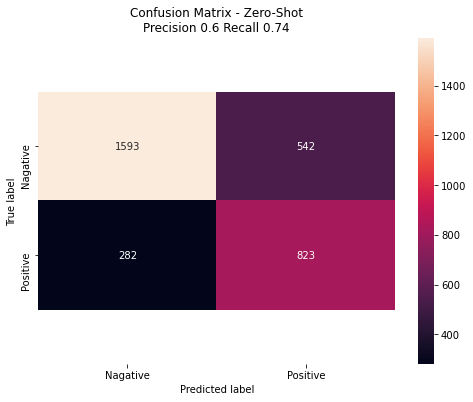

In [29]:
def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = matrix.ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Nagative', 'Positive'], 
                         columns = ['Nagative', 'Positive'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_matrix(olid_test.toxic, olid_test.toxic_predict_binary, name = 'Zero-Shot')


# Olid Few-shot

In [30]:
model_1k = model
model_1k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train_1k.shape[0] // BATCH_SIZE
train_history_1k = model_1k.fit(
    olid_train_1k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test1k = olid_test
olid_test1k.toxic_predict = model_1k.predict(olid_test_dataset, verbose=1)
olid_test1k.to_csv('olid_test_1k.csv', index=False)

print('1k roc is ' + str(roc_auc_score(y_true = olid_test1k.toxic, y_score = olid_test1k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test1k.toxic, olid_test1k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test1k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test1k.toxic_predict]

print('1k f1-score is ' + str(f1_score(y_true = olid_test1k.toxic, y_pred = olid_test1k.toxic_predict_binary)))

del model_1k

Epoch 1/5
15/15 [==============================] - 55s 4s/step - loss: 0.5011 - accuracy: 0.7990 - val_loss: 0.5422 - val_accuracy: 0.7688
Epoch 2/5
15/15 [==============================] - 6s 425ms/step - loss: 0.5181 - accuracy: 0.7959 - val_loss: 0.5419 - val_accuracy: 0.7698
Epoch 3/5
15/15 [==============================] - 6s 424ms/step - loss: 0.5075 - accuracy: 0.7959 - val_loss: 0.5415 - val_accuracy: 0.7698
Epoch 4/5
15/15 [==============================] - 6s 426ms/step - loss: 0.5121 - accuracy: 0.8045 - val_loss: 0.5411 - val_accuracy: 0.7704
Epoch 5/5
51/51 [==============================] - 4s 81ms/step
1k roc is 0.8212425953988152
the optimal threshold is 0.1531369388103485
1k f1-score is 0.6663967611336031


In [31]:
model_2k = model
model_2k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train_2k.shape[0] // BATCH_SIZE
train_history_2k = model_2k.fit(
    olid_train_2k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test2k = olid_test
olid_test2k.toxic_predict = model_2k.predict(olid_test_dataset, verbose=1)
olid_test2k.to_csv('olid_test_2k.csv', index=False)

print('2k roc is ' + str(roc_auc_score(y_true = olid_test2k.toxic, y_score = olid_test2k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test2k.toxic, olid_test2k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test2k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test2k.toxic_predict]

print('2k f1-score is ' + str(f1_score(y_true = olid_test2k.toxic, y_pred = olid_test2k.toxic_predict_binary)))

del model_2k

Epoch 1/5
31/31 [==============================] - 57s 2s/step - loss: 0.5078 - accuracy: 0.7923 - val_loss: 0.5401 - val_accuracy: 0.7710
Epoch 2/5
31/31 [==============================] - 8s 258ms/step - loss: 0.4993 - accuracy: 0.7970 - val_loss: 0.5394 - val_accuracy: 0.7704
Epoch 3/5
31/31 [==============================] - 8s 258ms/step - loss: 0.5054 - accuracy: 0.7996 - val_loss: 0.5387 - val_accuracy: 0.7698
Epoch 4/5
31/31 [==============================] - 8s 256ms/step - loss: 0.5029 - accuracy: 0.7913 - val_loss: 0.5380 - val_accuracy: 0.7694
Epoch 5/5
51/51 [==============================] - 4s 81ms/step
2k roc is 0.8213087202093952
the optimal threshold is 0.15735599398612976
2k f1-score is 0.6666666666666667


In [32]:
model_5k = model
model_5k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train_5k.shape[0] // BATCH_SIZE
train_history_5 = model_5k.fit(
    olid_train_5k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test5k = olid_test
olid_test5k.toxic_predict = model_5k.predict(olid_test_dataset, verbose=1)
olid_test5k.to_csv('olid_test_5k.csv', index=False)

print('5k roc is ' + str(roc_auc_score(y_true = olid_test5k.toxic, y_score = olid_test5k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test5k.toxic, olid_test5k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test5k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test5k.toxic_predict]

print('5k f1-score is ' + str(f1_score(y_true = olid_test5k.toxic, y_pred = olid_test5k.toxic_predict_binary)))

del model_5k

Epoch 1/5
78/78 [==============================] - 65s 837ms/step - loss: 0.4949 - accuracy: 0.7941 - val_loss: 0.5356 - val_accuracy: 0.7694
Epoch 2/5
78/78 [==============================] - 13s 160ms/step - loss: 0.4994 - accuracy: 0.7921 - val_loss: 0.5340 - val_accuracy: 0.7694
Epoch 3/5
78/78 [==============================] - 13s 162ms/step - loss: 0.4951 - accuracy: 0.7936 - val_loss: 0.5324 - val_accuracy: 0.7694
Epoch 4/5
78/78 [==============================] - 13s 162ms/step - loss: 0.5021 - accuracy: 0.7915 - val_loss: 0.5309 - val_accuracy: 0.7701
Epoch 5/5
51/51 [==============================] - 4s 81ms/step
5k roc is 0.8214697934659361
the optimal threshold is 0.16963237524032593
5k f1-score is 0.6669364629704574


In [33]:
model_10k = model
model_10k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train.shape[0] // BATCH_SIZE
train_history_10 = model_10k.fit(
    olid_train_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test10k = olid_test
olid_test10k.toxic_predict = model_10k.predict(olid_test_dataset, verbose=1)
olid_test10k.to_csv('olid_test_10k.csv', index=False)

print('10k roc is ' + str(roc_auc_score(y_true = olid_test10k.toxic, y_score = olid_test10k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test10k.toxic, olid_test10k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test10k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test10k.toxic_predict]

print('10k f1-score is ' + str(f1_score(y_true = olid_test10k.toxic, y_pred = olid_test10k.toxic_predict_binary)))

del model_10k


Epoch 1/5
156/156 [==============================] - 70s 448ms/step - loss: 0.5017 - accuracy: 0.7895 - val_loss: 0.5262 - val_accuracy: 0.7704
Epoch 2/5
156/156 [==============================] - 20s 131ms/step - loss: 0.4977 - accuracy: 0.7882 - val_loss: 0.5234 - val_accuracy: 0.7719
Epoch 3/5
156/156 [==============================] - 20s 130ms/step - loss: 0.4963 - accuracy: 0.7872 - val_loss: 0.5206 - val_accuracy: 0.7710
Epoch 4/5
156/156 [==============================] - 21s 132ms/step - loss: 0.4955 - accuracy: 0.7876 - val_loss: 0.5180 - val_accuracy: 0.7713
Epoch 5/5
51/51 [==============================] - 4s 80ms/step
10k roc is 0.8217669312365551
the optimal threshold is 0.19509762525558472
10k f1-score is 0.6682887266828874
